# Changes from v8
* Shuffled the data
* Added these parameters to my vectorizer:  min_df = 3, sublinear_tf=True
* Accuracy is 43.283%
* Updated stop words
* Accuracy is 43.288%
* Removed lowest level of predicted words == min
* Accuracy is 43.708%
* Removed bottom half of the lowest level of predicted words 
* Accuracy is 44.37%
* Running only the top 100 words for each CPT code decreased accuracy back to 43%


# Import the MIMIC data

In [1]:
import gzip
import pandas as pd
import glob

dataset_dictionary = {}

for file_path in glob.glob('.\\Data\\MIMIC Files\*'):
    file_name = file_path.split('\\')[3].split('.')[0]
    with gzip.open(file_path, mode='r') as file:
        dataset_dictionary[file_name] = pd.read_csv(file)

c:\users\amartins\onedrive - intermountain healthcare\python_pycharm_virt_env\.venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
c:\users\amartins\onedrive - intermountain healthcare\python_pycharm_virt_env\.venv\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Join the tables

In [2]:
# Create dataset to join together -----

# Create note_events table -----

# Combine text for each subject and encounter
note_events_base = dataset_dictionary['NOTEEVENTS'][dataset_dictionary['NOTEEVENTS'].loc[:,'CATEGORY'] == 'Discharge summary']
note_events = note_events_base.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False)['TEXT'].agg(sum)

# Create CPT table -----

cpt_events_base = dataset_dictionary['CPTEVENTS'].loc[:, ['SUBJECT_ID','HADM_ID', 'CPT_CD']]
cpt_events = cpt_events_base.drop_duplicates()

# Join the datasets -----

note_cpt = note_events.merge(cpt_events, on = ['SUBJECT_ID','HADM_ID'])
# print(note_cpt.shape, note_events.shape, cpt_events.shape) # (223,150, 4) (52,726, 3) (227,510, 3)

# Filter the data to just 3 CPT codes: 99291, 99232, 94003

In [3]:
note_cpt_4 = note_cpt[note_cpt['CPT_CD'].astype(str).isin(['99291', '99232', '94003'])]

# Check for Imbalance

<BarContainer object of 3 artists>

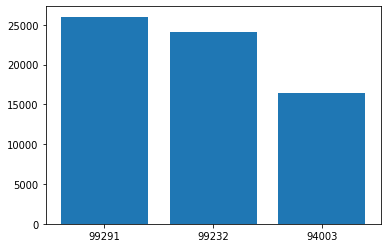

In [4]:
import matplotlib.pyplot as plt

x = note_cpt_4['CPT_CD'].astype(str).value_counts()

plt.bar(x.index, x)

# Filter the data

In [5]:
import string

def clean_data(text_series):
    
    # Replace \n 
    text_series = text_series.str.replace('\\n',' ', regex=True)    

    # Remove dates and locations
    text_series = text_series.str.replace('\[\*\*(.*?)\*\*\]', ' ', regex=True)
    
    # Remove topics
    data = text_series.str.split('([A-Z\s]+:)')
    for row_num, value in enumerate(data):
        text_chunks = [x.strip().replace(':','').replace('\n', '') for x in value]
        for i, x in enumerate(text_chunks):
            if 'MEDICATION' in x or 'SOCIAL HISTORY' in x or 'FAMILY HISTORY' in x:
                text_chunks[i] = ' '
                try:
                    text_chunks[i + 1] = ' '
                except:
                    continue

        text_series.iloc[row_num] = ' '.join(text_chunks)
    
    # Replace punctuation
    text_series = text_series.str.replace('[' + string.punctuation + ']', ' ', regex=True)
    
    # Convert to lowercase 
    text_series = text_series.str.lower()
    
    # Remove all digits
    text_series = text_series.str.replace('\d',' ', regex=True)
    
    return text_series

note_cpt_4_clean = clean_data(note_cpt_4['TEXT'])
note_cpt_4_clean

1         admission date        discharge date     date ...
4         admission date        discharge date     date ...
10        admission date          discharge date     dat...
11        admission date          discharge date     dat...
13        admission date          discharge date    date...
                                ...                        
223123    admission date                 discharge date ...
223124    admission date                 discharge date ...
223130    admission date                 discharge date ...
223134    admission date                 discharge date ...
223135    admission date                 discharge date ...
Name: TEXT, Length: 66480, dtype: object

# Update text column

In [6]:
note_cpt_4.loc[:, 'TEXT'] = note_cpt_4_clean.values

c:\users\amartins\onedrive - intermountain healthcare\python_pycharm_virt_env\.venv\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# Shuffle the Data

In [7]:
note_cpt_4 = note_cpt_4.sample(n = len(note_cpt_4), random_state = 42)

# Split the Data

In [65]:
# Import Packages -----

from nltk.corpus import stopwords

my_stop_words = list(set(stopwords.words('english'))) \
                + ['admission', 'date', 'sex'] \
                + ['needed', 'every', 'seen', 'weeks', 'please', 'ml', 'unit', 'small', 'year', 'old', 'cm', 'non', 'mm', 'however']
                # Got the above from my top 100 most predictive words that I wanted to remove

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the data -----

X_train, X_test, y_train, y_test = train_test_split(note_cpt_4['TEXT'].values, note_cpt_4['CPT_CD'].astype(str), test_size = .33, random_state = 42)

# Tokenize the data

In [66]:
# Tokenize the data -----

# Import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=my_stop_words, min_df = 3, max_df = .7, sublinear_tf=True)

# Transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test)

# Run Naive Bayes

In [68]:
# Use Naive Bayes model -----

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb_classifier = MultinomialNB(alpha=.7)

# Fit and check accuracy
nb_classifier.fit(tfidf_train, y_train)
pred = nb_classifier.predict(tfidf_test)

# Tune NB Model

In [18]:
import numpy as np


def hyperparam_tuning(tfidf_train, y_train, tfidf_test, y_test, nb_classifier):
    for i in np.arange(0,1.1,.1):
        nb_classifier = MultinomialNB()
        nb_classifier.fit(tfidf_train, y_train)
        pred = nb_classifier.predict(tfidf_test)
        print(i)
        print(metrics.accuracy_score(y_test, pred))

hyperparam_tuning(tfidf_train, y_train, tfidf_test, y_test, nb_classifier)  

# Looks like .6-.7 are the best alpha

0.0
0.421076621541547
0.1
0.421076621541547
0.2
0.421076621541547
0.30000000000000004
0.421076621541547
0.4
0.421076621541547
0.5
0.421076621541547
0.6000000000000001
0.421076621541547
0.7000000000000001
0.421076621541547
0.8
0.421076621541547
0.9
0.421076621541547
1.0
0.421076621541547


# Run Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression

clf_logist = LogisticRegression(C=.001, random_state = 42, multi_class = 'multinomial', penalty='l2')
clf_logist.fit(tfidf_train, y_train)
logist_pred = clf_logist.predict(tfidf_test)

c:\users\amartins\onedrive - intermountain healthcare\python_pycharm_virt_env\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Looking at Feature Names and Weights

In [95]:
# Notes
# sum([np.exp(1)** x for x in nb_classifier.coef_[0]]) # The probability of all the words equals one
# # Taken from here: * https://stackoverflow.com/questions/61586946/how-to-calculate-feature-log-prob-in-the-naive-bayes-multinomialnb

# ------------------------------------------

import numpy as np

def get_feature_rank(tfidf_vectorizer, y_no, nb_classifier):
    
    # Get the feature names
    feature_names = tfidf_vectorizer.get_feature_names()

    # Zip together the first CPT weights with feature names
    feat_with_weights =  sorted(zip(nb_classifier.coef_[y_no], feature_names))
    
    # Print words most responsible for the prediction
#     print('Top 100 \n\n\n\n')
#     top_100_ls = []
    for i in range(100):
        x = feat_with_weights[-i-1]
#         top_100_ls.append(x[1])
#         print(nb_classifier.classes_[y_no], i, round((np.exp(1) ** x[0]),4), x[1])

#     print('\n\n\n\n Bottom 100 \n\n\n\n')
    for i in range(100):
        x = feat_with_weights[i]
#         print(nb_classifier.classes_[y_no], i, round((np.exp(1) ** x[0]),4), x[1])
    
#     min_weight = min([i[0] for i in feat_with_weights])
    
    x = [i[0] for i in feat_with_weights]
    
    median_pred = np.median(x)
          
    return [i[1] for i in feat_with_weights if i[0] <= median_pred] # Minimum weight words
#     return top_100_ls

# Find the least predictive words
def least_pred_words(nb_classifier, tfidf_vectorizer):
    low_wt_stop_ls = []

    for i in range(len(nb_classifier.classes_)):
        low_wt_stop_ls += get_feature_rank(tfidf_vectorizer, i, nb_classifier)

    low_wt_stop_ls = list(set(low_wt_stop_ls))
    return low_wt_stop_ls
    
low_wt_stop_ls = least_pred_words(nb_classifier, tfidf_vectorizer)

# Find top 100 words - doesn't seem to improve the model
def highest_pred_words(nb_classifier, tfidf_vectorizer):
    top_100_ls = []
    for i in range(len(nb_classifier.classes_)):
        top_100_ls += get_feature_rank(tfidf_vectorizer, i, nb_classifier)

    top_100_ls = list(set(top_100_ls))
    return top_100_ls

33442

# Update stop words and tokenize again

In [96]:
my_stop_words += low_wt_stop_ls

tfidf_vectorizer = TfidfVectorizer(stop_words=my_stop_words, min_df = 3, max_df = .7, sublinear_tf=True)

# Transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test)


# Create Vocab with top words and tokenize again

In [ ]:
# It reduced test accuracy back to 43% and training went from 50% to 44%

tfidf_vectorizer = TfidfVectorizer(vocabulary=top_100_ls, stop_words=my_stop_words, min_df = 3, max_df = .7, sublinear_tf=True)

# Transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test)


# Run Naive Bayes again

In [97]:
# Use Naive Bayes model -----

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb_classifier = MultinomialNB(alpha=.7)

# Fit and check accuracy
nb_classifier.fit(tfidf_train, y_train)
pred = nb_classifier.predict(tfidf_test)

# Classification Report

In [98]:
# Create classification report taken from here: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
from sklearn.metrics import classification_report

print('Test')
class_labels = nb_classifier.classes_
print(classification_report(y_test, pred,target_names=class_labels))

print('Training')
pred_x = nb_classifier.predict(tfidf_train)
print(classification_report(y_train, pred_x,target_names=class_labels))


Test
              precision    recall  f1-score   support

       94003       0.47      0.48      0.47      5484
       99232       0.42      0.29      0.34      7842
       99291       0.44      0.56      0.49      8613

    accuracy                           0.44     21939
   macro avg       0.44      0.44      0.44     21939
weighted avg       0.44      0.44      0.44     21939

Training
              precision    recall  f1-score   support

       94003       0.49      0.51      0.50     10948
       99232       0.51      0.34      0.41     16196
       99291       0.48      0.62      0.54     17397

    accuracy                           0.49     44541
   macro avg       0.49      0.49      0.48     44541
weighted avg       0.49      0.49      0.48     44541



In [99]:
metrics.accuracy_score(y_test, pred)

# """
# V1 NLP Model Accuracy: 0.117
# Wow, I've got a long way to go to improve accuracy
# V2 NLP Model Accuracy: 0.14
# V3 NLP Model Accuracy: .40
# """

# Confusion matrix 
# confusion_mtrx = metrics.confusion_matrix(y_test.astype(str), pred) # 1380, 1380
# confusion_mtrx

0.44368476229545556

In [39]:
# Logistical Model accuracy
metrics.accuracy_score(y_test, logist_pred)
# .39



0.3560782168740599

# Vectorize Test

In [84]:
from sklearn.feature_extraction.text import CountVectorizer

vocab = ['love', 'happy', 'run']
count_vectorizer = CountVectorizer(vocabulary = vocab)
x = count_vectorizer.fit_transform(['happy', 'run', 'run', 'run'])
print(x)

  (0, 1)	1
  (1, 2)	1
  (2, 2)	1
  (3, 2)	1
